<a href="https://colab.research.google.com/github/nebuus/fun/blob/extra/Cat_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation  # this is needed for the animation API
import matplotlib.image as mpimg # for grayscale input image
from matplotlib.colors import Normalize   # this is needed to rescale the color during the simulation

In [ ]:
#@title Def functions
def get_initial_configuration(N, random_influence=0.2):
    """
    N is the side length of the (N x N)-sized grid.
    `random_influence` describes how much noise is added.
    """

    # We start with a configuration where on every grid cell
    # there's a lot of chemical A, so the concentration is high
    AA = (1-random_influence) * np.ones((N,N)) + random_influence * np.random.random((N,N))

    # Let's assume there's only a bit of B everywhere
    BB = random_influence * np.random.random((N,N))

    return AA, BB

def draw(A,B):
    """draw the concentrations"""
    %matplotlib inline
    plt.clf()
    fig, ax = plt.subplots(1,2,figsize=(5.65,4))
    ax[0].imshow(A, cmap='Greys')
    ax[1].imshow(B, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

    plt.show()

def discrete_laplacian1(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0, 1), (0, 1))  # right neighbor
    L += np.roll(M, (0, -1), (0, 1))  # left neighbor
    L += np.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += np.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

def gray_scott_update1(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    #A, B = torch.tensor(A.detach().cpu().numpy()), torch.tensor(B.detach().cpu().numpy())

    # Let's get the discrete Laplacians first
    LA = discrete_laplacian1(A)
    LB = discrete_laplacian1(B)

    # Now apply the update formula
    diff_A = (DA*LA - A*B**2 + f*(1-A)) * delta_t
    diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t

    A_res = A + diff_A
    B_res = B + diff_B

    return A_res, B_res

<Figure size 640x480 with 0 Axes>

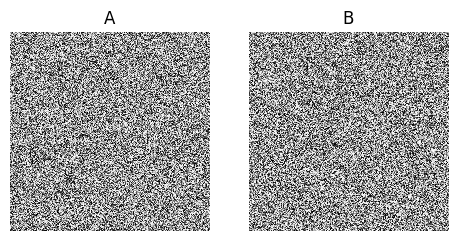

In [ ]:
#@title Get initial configuration {vertical-output: true}
%matplotlib inline
A_init, B_init = get_initial_configuration(200)
draw(A_init, B_init)

<Figure size 640x480 with 0 Axes>

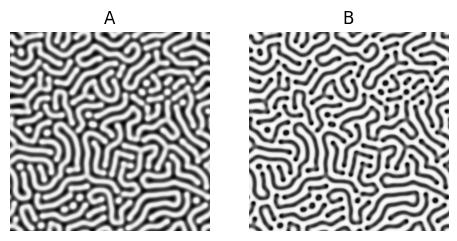

In [ ]:
#@title Get the synthetic target configuration {vertical-output: true}
# update in time
delta_t = 1.0

# simulation steps
N_simulation_steps = 2000

A_res, B_res = A_init, B_init

DA, DB, f, k = 0.14, 0.06, 0.040, 0.062 # bacteria
for t in range(N_simulation_steps):
    A_res, B_res = gray_scott_update1(A_res, B_res, DA, DB, f, k, delta_t)

A_target, B_target = A_res, B_res

draw(A_target,B_target)

<Figure size 640x480 with 0 Axes>

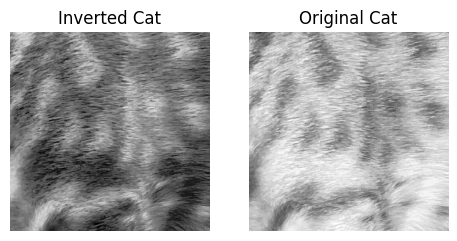

In [ ]:
#@title Get the target configuration from image {vertical-output: true}
# importing pic, turning it grayscale and plotting it
from skimage import io
from skimage.transform import resize
img = resize(io.imread('/content/cut1.jpg', as_gray=True), (200, 200))
inverted_img = 1 - img
plt.clf()
fig, ax = plt.subplots(1,2,figsize=(5.65,4))
ax[0].imshow(img, cmap='Greys')
ax[0].set_title('Inverted Cat')
ax[0].axis('off')
ax[1].imshow(inverted_img, cmap='Greys')
ax[1].set_title('Original Cat')
ax[1].axis('off')
plt.show()

NameError: ignored

# reinforcement NN part

In [ ]:
##
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4 * M
    L += torch.roll(M, (0, 1), (0, 1))  # right neighbor
    L += torch.roll(M, (0, -1), (0, 1))  # left neighbor
    L += torch.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += torch.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

def gray_scott_update(A, B, DA, DB, f, k, delta_t, N_simulation_steps):
    for t in range(N_simulation_steps):
        # discrete Laplacians
        LA = discrete_laplacian(A.detach())
        LB = discrete_laplacian(B.detach())

        # Update in time
        diff_A = (DA * LA - A * B**2 + f * (1 - A)) * delta_t
        diff_B = (DB * LB + A * B**2 - (k + f) * B) * delta_t

        A = A + diff_A
        B = B + diff_B

    A_updated, B_updated = A, B

    return A_updated, B_updated

In [ ]:
# Define a neural network to learn f and k
class GrayScottModel(nn.Module):
    def __init__(self):
        super(GrayScottModel, self).__init__()
        self.f = nn.Parameter(torch.tensor(0.03,requires_grad=True))
        self.k = nn.Parameter(torch.tensor(0.06, requires_grad=True))

    def forward(self, A, B, DA, DB, delta_t, N_simulation_steps):
        f_clamped = torch.sigmoid(self.f)
        k_clamped = torch.sigmoid(self.k)
        A_updated, B_updated = gray_scott_update(A, B, DA, DB, f_clamped, k_clamped, delta_t, N_simulation_steps)
        return A_updated, B_updated

In [ ]:
A_updated = torch.tensor(A_init, dtype=torch.float32, requires_grad=True)
B_updated = torch.tensor(B_init, dtype=torch.float32, requires_grad=True)

A_target_tensor = torch.tensor(A_target, dtype=torch.float32, requires_grad=True)
B_target_tensor = torch.tensor(B_target, dtype=torch.float32, requires_grad=True)

In [ ]:
# Instantiate the model, set up optimizer, and define the loss function
model = GrayScottModel()
optimizer = optim.Adam(model.parameters(), lr=0.02)
criterion = nn.MSELoss()

# Training loop
num_epochs = 300
delta_t = 1.0
DA = 0.14
DB = 0.06
N_simulation_steps = 20
#learning_rate = 0.001

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    A_updated, B_updated = model(A_updated, B_updated, DA, DB, delta_t, N_simulation_steps)

    A_tensor, B_tensor = A_updated, B_updated

    # Compute loss
    loss_A = criterion(A_tensor, A_target_tensor)
    loss_B = criterion(B_tensor, B_target_tensor)

    # Backward pass and optimization
    loss_A.backward(retain_graph=True)
    loss_B.backward(retain_graph=True)

    optimizer.step()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    f_clamped = torch.clamp(torch.sigmoid(model.f), 0, 1)
    k_clamped = torch.sigmoid(model.k)

    loss = loss_A + loss_B

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get the optimized parameters
f_optimized, k_optimized = model.f.item(), model.k.item()
print(f'Optimized Parameters: f={f_clamped}, k={k_clamped}')

Epoch [100/6000], Loss: 0.0429
Epoch [200/6000], Loss: 0.0429


KeyboardInterrupt: ignored

In [ ]:
f_optimized, k_optimized = model.f.item(), model.k.item()
print(f'Optimized Parameters: f={f_clamped}, k={k_clamped}')

Optimized Parameters: f=0.4936599135398865, k=0.5147358179092407


# Drawing the NN output

In [ ]:
# {vertical-output: true}
delta_t = 200.0

# simulation steps
N_simulation_steps = 1

DA, DB = 0.14, 0.06
f = f_clamped
k = k_clamped
for t in range(N_simulation_steps):
    A_check, B_check = gray_scott_update1(A_init, B_init, DA, DB, f, k, delta_t)

draw(A_check,B_check)

NameError: ignored

<Figure size 640x480 with 0 Axes>

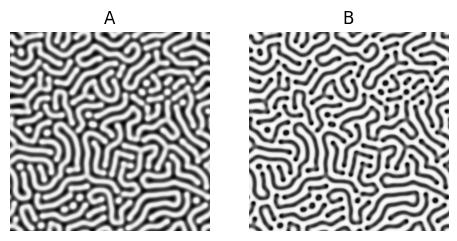

In [ ]:
# {vertical-output: true}
draw(A_target,B_target)

#Transfer learning approach

In [ ]:
# Creating training data by generating a bunch of 200x200 images
delta_t = 1.0
N_simulation_steps = 2000
f_values = np.arange(0.002, 0.120, 0.001)
k_values = np.arange(0.014, 0.035, 0.001)
A_res, B_res = A_init, B_init
DA, DB = 0.14, 0.06
training = []

for f in f_values:
  for k in k_values:
    A_res, B_res = A_init, B_init

    for t in range(N_simulation_steps):
        A_res, B_res = gray_scott_update1(A_res, B_res, DA, DB, f, k, delta_t)

    training.append({
          'f': f.item(),
          'k': k,
          'A_target': A_res,
          'B_target': B_res
      })

np.save('training.npy', np.array(training, dtype=object), allow_pickle=True)

In [ ]:
len(training)

2596

<Figure size 640x480 with 0 Axes>

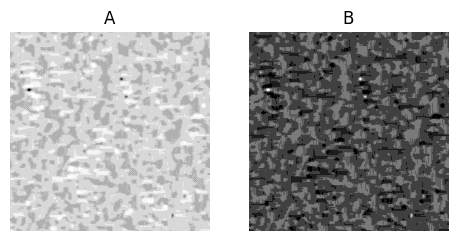

In [ ]:
# Checking if it did it sort of right
aaa = training[1000]['A_target']
bbb = training[1000]['B_target']
draw(aaa, bbb)

#cNN for realz for realz

In [ ]:
# Splitting the data in 2 - inputs and targets
# annotations = [{'f': row['f'], 'k': row['k']} for row in training]
# imgs = [{'A_target': line['A_target'], 'B_target': line['B_target']} for line in training]

annotations = []
imgs = []
for trainingData in training:
  annotations.append({'f': trainingData['f'], 'k': trainingData['k']})
  imgs.append({'A_target': trainingData['A_target'], 'B_target': trainingData['B_target']})

In [ ]:
#torch.multiprocessing.set_start_method('spawn')
device = ("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(66)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.fromarray((self.data[idx]['A_target'] * 255).astype(np.uint8))  # Assuming image is stored in 'image' key
        label = torch.tensor([self.data[idx]['k'], self.data[idx]['f']], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label

# Load your dataset and split into training and testing sets
# Make sure to replace this with your actual data loading logic
# Assume your data is a list of dictionaries with 'image', 'k', and 'f' keys
data = training  # Replace with your data loading code

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

# Define transformations for the images (adjust as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create instances of the custom dataset
train_dataset = CustomDataset(train_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the VGG model with modified output for 2 float values
class CustomVGG(nn.Module):
    def __init__(self):
        super(CustomVGG, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        # Modify the first layer to accept 1 channel instead of 3
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 2)  # Output layer with 2 neurons for k and f
        )

    def forward(self, x):
        return self.vgg(x)

# Instantiate the model
model = CustomVGG()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print training loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss = criterion(outputs, labels)

    print(f'Test Loss: {test_loss.item():.4f}')


Epoch [1/10], Loss: 0.0009
Epoch [2/10], Loss: 0.0006
Epoch [3/10], Loss: 0.0006
Epoch [4/10], Loss: 0.0003


In [3]:
torch.save(model.state_dict(), '/content/cat_model.pth')

# Load the model later
#model = CustomVGG()
#model.load_state_dict(torch.load('path/to/save/model.pth'))
#model.eval()

NameError: ignored

In [ ]:
git init
git add /content/cat_model.pth
git commit -m "Add trained model weights"
git remote add origin https://github.com/nebuus/fun/tree/extra.git

# Push the changes to GitHub
git push -u origin master

In [160]:
sample_input = torch.randn((1, 1, 200, 200))
output_size = model(sample_input).size()

print("Output size:", output_size)

Output size: torch.Size([1, 1000])


In [ ]:
check_accuracy(test_loader, model)

NameError: ignored

In [154]:
from sklearn.metrics import precision_score, f1_score, recall_score
model.to('cpu')
y_pred, y_true = get_predictions(test_loader)

f1 = f1_score(y_true, y_pred, average='macro')
recall_score = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')

print(f'Performance scores: precision={precision}, recall={recall_score}, f1 = {f1}')

ValueError: ignored